# Effects of Initial Condition in the GS Model

By keeping all paramters constant and domain consistent as a 64 X 64 square, we visualized the evolution of pattern with ADI method with 4 different initial conditions.

We chose to use ADI method to compute the solution for the PDE equations since it is comparatively the most accurate (2-nd order) and the most stable (allows the largest dt) among all the 4 methods we tried.

In [1]:
# import libraries
import numpy as np
from util import *
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import time
from IPython.display import HTML
%matplotlib inline

## Experiments Parameters Setup

### Varied Initial Conditions 
```python
# 1. V: a centered cluster of ones
U_init = np.zeros((Ny, Nx))
V_init = np.zeros((Ny, Nx))
U_init[:, :] = 1
j_0 = int(3/8*Ny) 
j_1 = int(5/8*Ny)
k_0 = int(3/8*Nx)
k_1 = int(5/8*Nx)
V_init[j_0:j_1, k_0:k_1] = 1

# 2. V: 2 square clusters of ones
U_init = np.zeros((Ny, Nx))
V_init = np.zeros((Ny, Nx))
U_init[:, :] = 1
ja_0 = int(3/8*Ny) 
ja_1 = int(4/8*Ny)
ka_0 = int(3/8*Nx)
ka_1 = int(4/8*Nx)
jb_0 = int(4/8*Ny) 
jb_1 = int(5/8*Ny)
kb_0 = int(4/8*Nx)
kb_1 = int(5/8*Nx)
V_init[ja_0:ja_1, ka_0:ka_1] = 1
V_init[jb_0:jb_1, kb_0:kb_1] = 1

# 3. V: 2 random clusters of ones
U_init = np.zeros((Ny, Nx))
V_init = np.zeros((Ny, Nx))
U_init[:, :] = 1
V_init[21:30, 11:17] = 1
V_init[30:35, 36:45] = 1

# 4. V: a centered band of ones
U_init = np.zeros((Ny, Nx))
V_init = np.zeros((Ny, Nx))
U_init[:, :] = 1
j_0 = int(7/16*Ny) 
j_1 = int(9/16*Ny)
V_init[j_0:j_1, :] = 1

```
### Other Controled Conditions
```python
Ny, Nx = 64, 64 # length of the sides of the entire grid
h = 2 # space step size, same in x and y direction
N = Nx * Ny # 1D length of the entire grid

Du = 1.0 # diffusion rate of u
Dv = 0.5 # diffusion rate of v
ff = 0.055 # feed rate, same as 'f' in the model PDE equation
kk = 0.062 # kill rate, same as 'k' in the model PDE equation

dt = 1.5 # time step size for ADI
end_t = 10000 # end time
time_steps = int(end_t / dt) # number of time steps of the entire evolution
```

dt = 1.5, time_steps = 6666


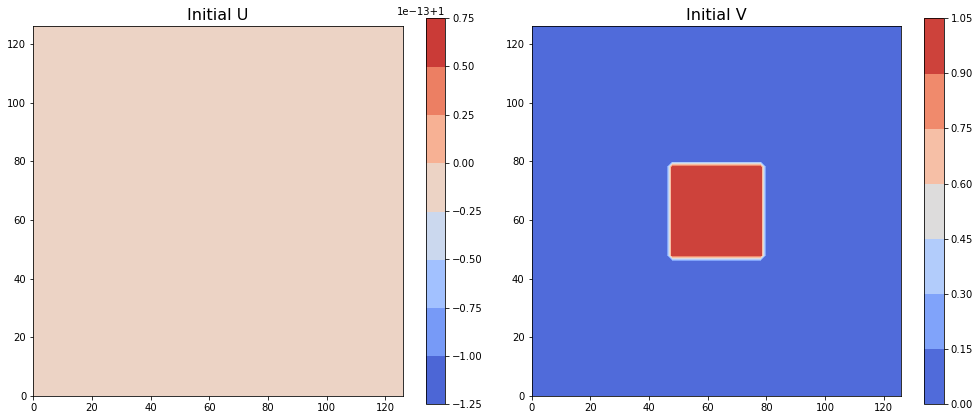

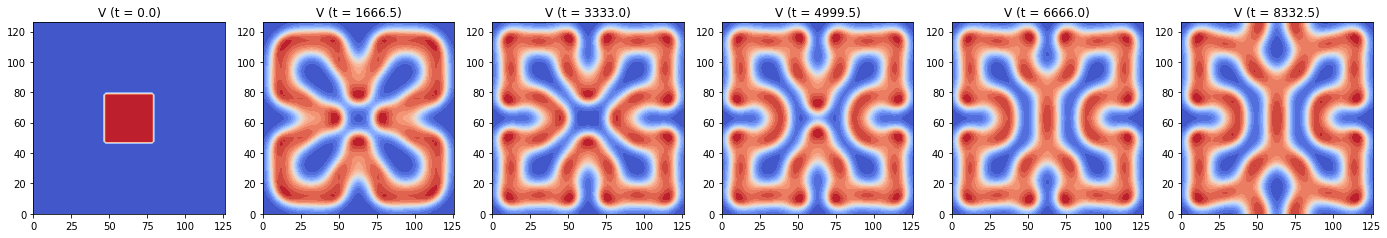

In [2]:
# Grid setup
Ny, Nx = 64, 64
h = 2
N = Nx * Ny

# Parameters setup
Du = 1.0
Dv = 0.5
ff = 0.055
kk = 0.062

# Time steps
dt = 1.5
end_t = 10000
time_steps = int(end_t / dt)
print('dt = {}, time_steps = {}'.format(dt, time_steps))
c = dt / (h * h)

# Construct transform matrices
D2x = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Nx, -1 + Nx], shape=(Nx, Nx))
D2y = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Ny, -1 + Ny], shape=(Ny, Ny))
Tu_x = sparse.eye(Nx) - 0.5 * Du * c * D2x
Tu_y = sparse.eye(Ny) - 0.5 * Du * c * D2y
Tv_x = sparse.eye(Nx) - 0.5 * Dv * c * D2x
Tv_y = sparse.eye(Ny) - 0.5 * Dv * c * D2y

# Factorize matrices
solve_Tu_x = linalg.factorized(Tu_x.tocsc())
solve_Tu_y = linalg.factorized(Tu_y.tocsc())
solve_Tv_x = linalg.factorized(Tv_x.tocsc())
solve_Tv_y = linalg.factorized(Tv_y.tocsc())

# Visualize initial condition --- V: a centered cluster of ones
U_init = np.zeros((Ny, Nx))
V_init = np.zeros((Ny, Nx))
U_init[:, :] = 1
j_0 = int(3/8*Ny) 
j_1 = int(5/8*Ny)
k_0 = int(3/8*Nx)
k_1 = int(5/8*Nx)
V_init[j_0:j_1, k_0:k_1] = 1
plot_init(U_init, V_init, h, filled=True)

U = np.zeros((time_steps, Ny, Nx))
V = np.zeros((time_steps, Ny, Nx))
U[0] = np.copy(U_init)
V[0] = np.copy(V_init)

# Generate pattern
for i in range(1, time_steps):
    
    # Stage one - solve along x direction
    b1U = 0.5 * Du * c * D2y.dot(U[i - 1]) \
        + (1 - 0.5 * dt * V[i - 1] ** 2 - 0.5 * dt * ff) * U[i - 1] + 0.5 * dt * ff
    b1V = 0.5 * Dv * c * D2y.dot(V[i - 1]) \
        + (1 - 0.5 * dt * kk - 0.5 * dt * ff) * V[i - 1] + 0.5 * dt * U[i - 1] * V[i - 1] ** 2

    U_middle = solve_Tu_x(b1U.T)
    V_middle = solve_Tv_x(b1V.T)

    # Stage two - solve along y direction
    b2U = 0.5 * Du * c * D2x.dot(U_middle) \
        + (1 - 0.5 * dt * V_middle ** 2 - 0.5 * dt * ff) * U_middle + 0.5 * dt * ff
    b2V = 0.5 * Dv * c * D2x.dot(V_middle) \
        + (1 - 0.5 * dt * kk - 0.5 * dt * ff) * V_middle + 0.5 * dt * U_middle * V_middle ** 2

    U[i] = solve_Tu_y(b2U.T)
    V[i] = solve_Tv_y(b2V.T)

plot_pattern_evolution(V, h, dt, time_steps, name='V', r=1, Nout=6)

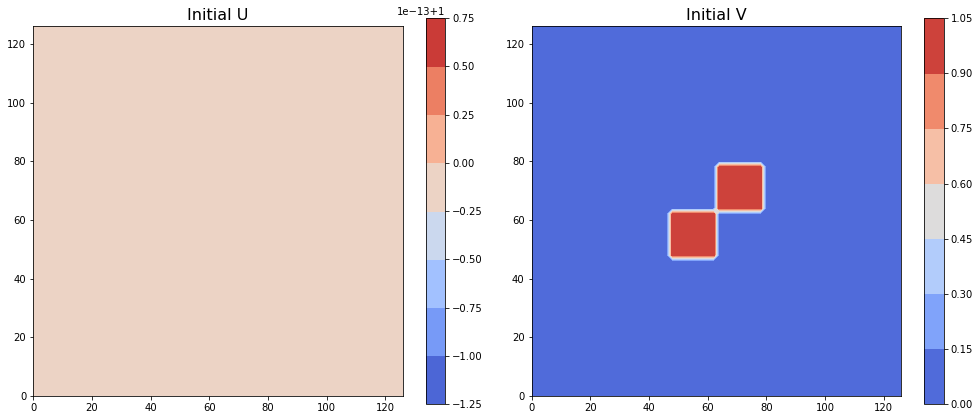

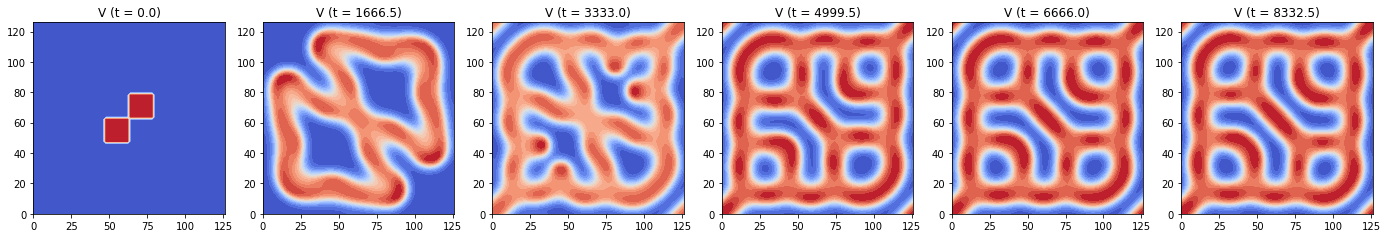

In [3]:
# Grid setup
Ny, Nx = 64, 64
h = 2
N = Nx * Ny

# Parameters setup
Du = 1.0
Dv = 0.5
ff = 0.055
kk = 0.062

# Time steps
dt = 1.5
end_t = 10000
time_steps = int(end_t / dt)
c = dt / (h * h)

# Construct transform matrices
D2x = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Nx, -1 + Nx], shape=(Nx, Nx))
D2y = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Ny, -1 + Ny], shape=(Ny, Ny))
Tu_x = sparse.eye(Nx) - 0.5 * Du * c * D2x
Tu_y = sparse.eye(Ny) - 0.5 * Du * c * D2y
Tv_x = sparse.eye(Nx) - 0.5 * Dv * c * D2x
Tv_y = sparse.eye(Ny) - 0.5 * Dv * c * D2y

# Factorize matrices
solve_Tu_x = linalg.factorized(Tu_x.tocsc())
solve_Tu_y = linalg.factorized(Tu_y.tocsc())
solve_Tv_x = linalg.factorized(Tv_x.tocsc())
solve_Tv_y = linalg.factorized(Tv_y.tocsc())

# Visualize initial condition --- V: 2 square clusters of ones
U_init = np.zeros((Ny, Nx))
V_init = np.zeros((Ny, Nx))
U_init[:, :] = 1
ja_0 = int(3/8*Ny) 
ja_1 = int(4/8*Ny)
ka_0 = int(3/8*Nx)
ka_1 = int(4/8*Nx)
jb_0 = int(4/8*Ny) 
jb_1 = int(5/8*Ny)
kb_0 = int(4/8*Nx)
kb_1 = int(5/8*Nx)
V_init[ja_0:ja_1, ka_0:ka_1] = 1
V_init[jb_0:jb_1, kb_0:kb_1] = 1
plot_init(U_init, V_init, h, filled=True)

U = np.zeros((time_steps, Ny, Nx))
V = np.zeros((time_steps, Ny, Nx))
U[0] = np.copy(U_init)
V[0] = np.copy(V_init)

# Generate pattern
for i in range(1, time_steps):
    
    # Stage one - solve along x direction
    b1U = 0.5 * Du * c * D2y.dot(U[i - 1]) \
        + (1 - 0.5 * dt * V[i - 1] ** 2 - 0.5 * dt * ff) * U[i - 1] + 0.5 * dt * ff
    b1V = 0.5 * Dv * c * D2y.dot(V[i - 1]) \
        + (1 - 0.5 * dt * kk - 0.5 * dt * ff) * V[i - 1] + 0.5 * dt * U[i - 1] * V[i - 1] ** 2

    U_middle = solve_Tu_x(b1U.T)
    V_middle = solve_Tv_x(b1V.T)

    # Stage two - solve along y direction
    b2U = 0.5 * Du * c * D2x.dot(U_middle) \
        + (1 - 0.5 * dt * V_middle ** 2 - 0.5 * dt * ff) * U_middle + 0.5 * dt * ff
    b2V = 0.5 * Dv * c * D2x.dot(V_middle) \
        + (1 - 0.5 * dt * kk - 0.5 * dt * ff) * V_middle + 0.5 * dt * U_middle * V_middle ** 2

    U[i] = solve_Tu_y(b2U.T)
    V[i] = solve_Tv_y(b2V.T)

plot_pattern_evolution(V, h, dt, time_steps, name='V', r=1, Nout=6)

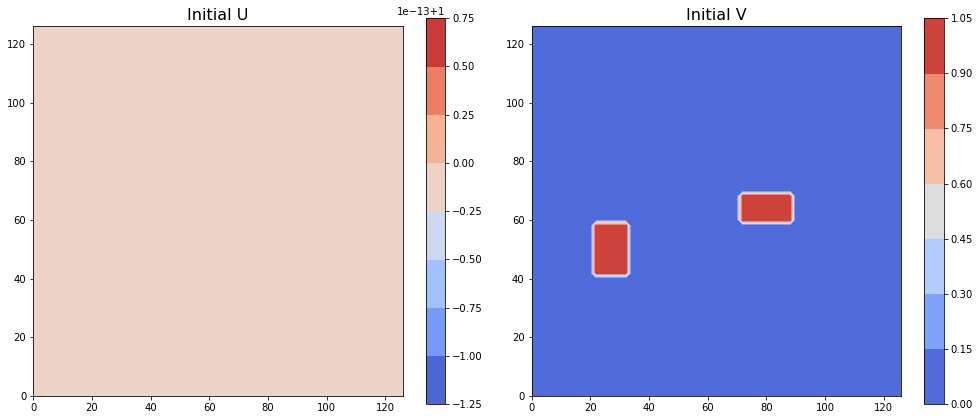

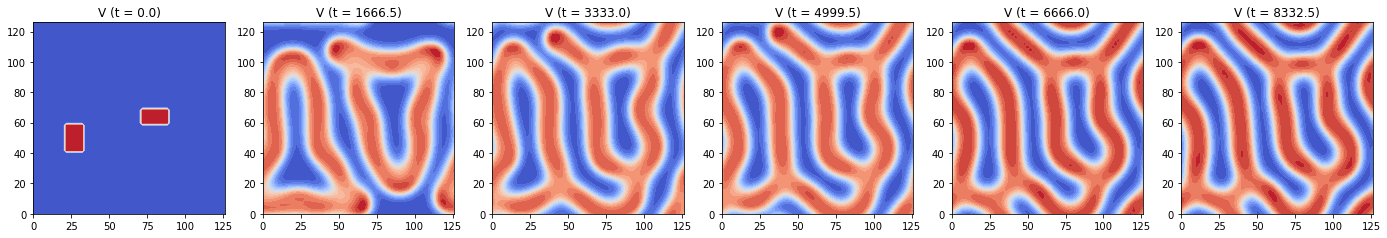

In [4]:
# Grid setup
Ny, Nx = 64, 64
h = 2
N = Nx * Ny

# Parameters setup
Du = 1.0
Dv = 0.5
ff = 0.055
kk = 0.062

# Time steps
dt = 1.5
end_t = 10000
time_steps = int(end_t / dt)
c = dt / (h * h)

# Construct transform matrices
D2x = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Nx, -1 + Nx], shape=(Nx, Nx))
D2y = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Ny, -1 + Ny], shape=(Ny, Ny))
Tu_x = sparse.eye(Nx) - 0.5 * Du * c * D2x
Tu_y = sparse.eye(Ny) - 0.5 * Du * c * D2y
Tv_x = sparse.eye(Nx) - 0.5 * Dv * c * D2x
Tv_y = sparse.eye(Ny) - 0.5 * Dv * c * D2y

# Factorize matrices
solve_Tu_x = linalg.factorized(Tu_x.tocsc())
solve_Tu_y = linalg.factorized(Tu_y.tocsc())
solve_Tv_x = linalg.factorized(Tv_x.tocsc())
solve_Tv_y = linalg.factorized(Tv_y.tocsc())

# Visualize initial condition --- V: 2 random clusters of ones
U_init = np.zeros((Ny, Nx))
V_init = np.zeros((Ny, Nx))
U_init[:, :] = 1
V_init[21:30, 11:17] = 1
V_init[30:35, 36:45] = 1
plot_init(U_init, V_init, h, filled=True)

U = np.zeros((time_steps, Ny, Nx))
V = np.zeros((time_steps, Ny, Nx))
U[0] = np.copy(U_init)
V[0] = np.copy(V_init)

# Generate pattern
for i in range(1, time_steps):
    
    # Stage one - solve along x direction
    b1U = 0.5 * Du * c * D2y.dot(U[i - 1]) \
        + (1 - 0.5 * dt * V[i - 1] ** 2 - 0.5 * dt * ff) * U[i - 1] + 0.5 * dt * ff
    b1V = 0.5 * Dv * c * D2y.dot(V[i - 1]) \
        + (1 - 0.5 * dt * kk - 0.5 * dt * ff) * V[i - 1] + 0.5 * dt * U[i - 1] * V[i - 1] ** 2

    U_middle = solve_Tu_x(b1U.T)
    V_middle = solve_Tv_x(b1V.T)

    # Stage two - solve along y direction
    b2U = 0.5 * Du * c * D2x.dot(U_middle) \
        + (1 - 0.5 * dt * V_middle ** 2 - 0.5 * dt * ff) * U_middle + 0.5 * dt * ff
    b2V = 0.5 * Dv * c * D2x.dot(V_middle) \
        + (1 - 0.5 * dt * kk - 0.5 * dt * ff) * V_middle + 0.5 * dt * U_middle * V_middle ** 2

    U[i] = solve_Tu_y(b2U.T)
    V[i] = solve_Tv_y(b2V.T)

plot_pattern_evolution(V, h, dt, time_steps, name='V', r=1, Nout=6)

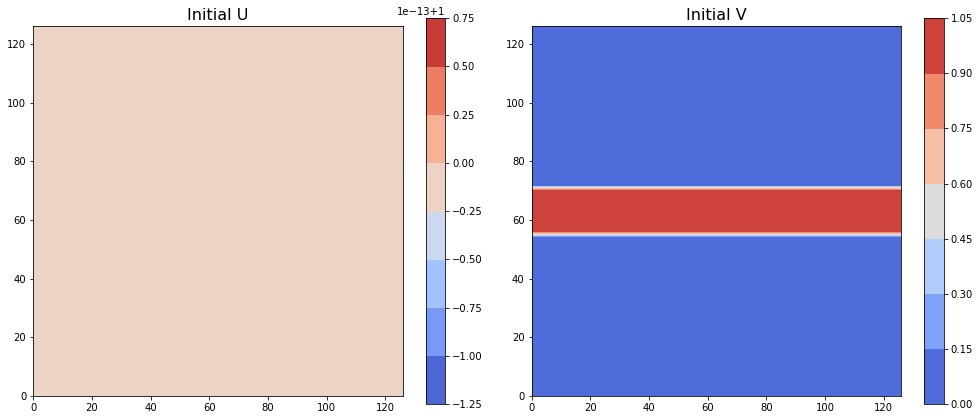

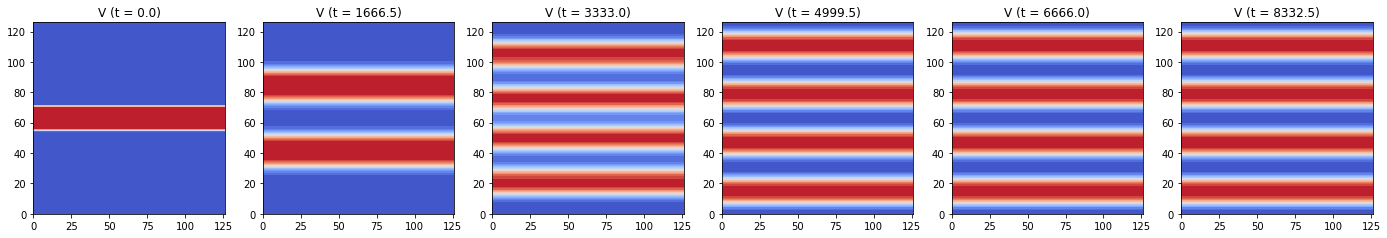

In [5]:
# Grid setup
Ny, Nx = 64, 64
h = 2
N = Nx * Ny

# Parameters setup
Du = 1.0
Dv = 0.5
ff = 0.055
kk = 0.062

# Time steps
dt = 1.5
end_t = 10000
time_steps = int(end_t / dt)
c = dt / (h * h)

# Construct transform matrices
D2x = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Nx, -1 + Nx], shape=(Nx, Nx))
D2y = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Ny, -1 + Ny], shape=(Ny, Ny))
Tu_x = sparse.eye(Nx) - 0.5 * Du * c * D2x
Tu_y = sparse.eye(Ny) - 0.5 * Du * c * D2y
Tv_x = sparse.eye(Nx) - 0.5 * Dv * c * D2x
Tv_y = sparse.eye(Ny) - 0.5 * Dv * c * D2y

# Factorize matrices
solve_Tu_x = linalg.factorized(Tu_x.tocsc())
solve_Tu_y = linalg.factorized(Tu_y.tocsc())
solve_Tv_x = linalg.factorized(Tv_x.tocsc())
solve_Tv_y = linalg.factorized(Tv_y.tocsc())

# Visualize initial condition --- V: a centered band of ones
U_init = np.zeros((Ny, Nx))
V_init = np.zeros((Ny, Nx))
U_init[:, :] = 1
j_0 = int(7/16*Ny) 
j_1 = int(9/16*Ny)
V_init[j_0:j_1, :] = 1
plot_init(U_init, V_init, h, filled=True)

U = np.zeros((time_steps, Ny, Nx))
V = np.zeros((time_steps, Ny, Nx))
U[0] = np.copy(U_init)
V[0] = np.copy(V_init)

# Generate pattern
for i in range(1, time_steps):
    
    # Stage one - solve along x direction
    b1U = 0.5 * Du * c * D2y.dot(U[i - 1]) \
        + (1 - 0.5 * dt * V[i - 1] ** 2 - 0.5 * dt * ff) * U[i - 1] + 0.5 * dt * ff
    b1V = 0.5 * Dv * c * D2y.dot(V[i - 1]) \
        + (1 - 0.5 * dt * kk - 0.5 * dt * ff) * V[i - 1] + 0.5 * dt * U[i - 1] * V[i - 1] ** 2

    U_middle = solve_Tu_x(b1U.T)
    V_middle = solve_Tv_x(b1V.T)

    # Stage two - solve along y direction
    b2U = 0.5 * Du * c * D2x.dot(U_middle) \
        + (1 - 0.5 * dt * V_middle ** 2 - 0.5 * dt * ff) * U_middle + 0.5 * dt * ff
    b2V = 0.5 * Dv * c * D2x.dot(V_middle) \
        + (1 - 0.5 * dt * kk - 0.5 * dt * ff) * V_middle + 0.5 * dt * U_middle * V_middle ** 2

    U[i] = solve_Tu_y(b2U.T)
    V[i] = solve_Tv_y(b2V.T)

plot_pattern_evolution(V, h, dt, time_steps, name='V', r=1, Nout=6)

## Summary
As visualized above, different initial conditions will generate different patterns. On the square domain, these patterns become more and more complicate as time goes but they **preserved the symmetry of the initial conditions**:

- the centered cluster of 1's formed a central point symmetric rectangular pattern
- the 2 square clusters of 1's formed a square-like pattern with the same symmetry of the initial 2 clusters
- the 2 random clusters of 1's formed an irregular pattern with the same symmetry of the initial 2 clusters
- the centered band of 1's formed a series of bands parallel to the initial band 